## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
from scipy.stats import sem
import numpy as np
from random import randrange
%matplotlib inline

In [2]:
# First step is to save the path to the csv files that I am going to use
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)
# Now I want to see what the dataframes look like so I will print out the first few rows of each
mouse_metadata_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [3]:
study_results_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [3]:
# # Combine the data into a single dataset
# Before merging the dataframes together I want to check what type of join to do to make sure that I do not lose any data
# To do this I will count the number of unique Mouse IDs in each dataframe and compare them 
unique_meta = mouse_metadata_df['Mouse ID'].unique()
unique_study = study_results_df['Mouse ID'].unique()
print(f"{len(unique_meta)} {len(unique_study)}")

249 249


In [4]:
# Since the number of Mouse IDs matches I can use an inner join and I will not lose any data
merge_df = pd.merge(study_results_df, mouse_metadata_df, on="Mouse ID")
# Display the data table for preview
merge_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


In [5]:
# Checking the number of mice.
number_mice = merge_df['Mouse ID'].unique()
print(f"There were {len(number_mice)} mice used in this study")

There were 249 mice used in this study


In [6]:
# Now I want to remove any rows where the same Mouse ID appears multiple times for the same Timepoint
# To do that I will first groupby these 2 columns 
mice_grouped_df = merge_df.groupby(["Mouse ID", "Timepoint"])

# Now I want to count how many times the Mouse ID appears for each Timepoint
# I choose to use the column header sex but any column would have worked 
duplicate_count = mice_grouped_df["Sex"].count()

duplicate_entry_df = pd.DataFrame(duplicate_count)
# Here I am creating a new dataframe with only the Mouse IDs that are in the same Timepoint more than once 
duplicates_df = duplicate_entry_df.loc[(duplicate_entry_df["Sex"] >= 2)]

In [7]:
# This shows me that only one Mouse ID has multiple of the same Timepoints
# This data was clearly entered in incorrectly so I am going to delete it, but before doing so I want to view all . . . 
# the data associated with this Mouse ID
duplicates_index = duplicates_df.index
duplicate_mouse_data = merge_df.loc[(merge_df["Mouse ID"] == duplicates_index[0][0])]
duplicate_mouse_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [8]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
merge_df = merge_df.loc[(merge_df["Mouse ID"] != duplicates_index[0][0])]

In [9]:
# Checking the number of mice in the clean DataFrame.
no_duplicate = merge_df['Mouse ID'].unique()
print(f"The correct number of mice used in this study is {len(no_duplicate)}. Certain values were entered incorrectly and had to be removed")

The correct number of mice used in this study is 248. Certain values were entered incorrectly and had to be removed


## Summary Statistics

In [10]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
regimen_grouped_df = merge_df.groupby(["Drug Regimen"])
tumor_mean = regimen_grouped_df['Tumor Volume (mm3)'].mean()
tumor_median = regimen_grouped_df['Tumor Volume (mm3)'].median()
tumor_sd = regimen_grouped_df['Tumor Volume (mm3)'].std()
tumor_var = tumor_sd**2
tumor_sem = regimen_grouped_df['Tumor Volume (mm3)'].sem()

tumor_statistics_df = pd.DataFrame(tumor_mean.map("{:.2f}".format))
tumor_statistics_df["Tumor Vol Median"] = tumor_median.map("{:.2f}".format)
tumor_statistics_df["Tumor Vol SD"] = tumor_sd.map("{:.2f}".format)
tumor_statistics_df["Tumor Vol Var"] = (tumor_var).map("{:.2f}".format)
tumor_statistics_df["Tumor Vol SEM"] = (tumor_sem).map("{:.2f}".format)
tumor_statistics_df = tumor_statistics_df.rename(columns={"Tumor Volume (mm3)":"Tumor Vol Mean"})

tumor_statistics_df

,Tumor Vol Mean,Tumor Vol Median,Tumor Vol SD,Tumor Vol Var,Tumor Vol SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,4.99,24.95,0.33
Ceftamin,52.59,51.78,6.27,39.29,0.47
Infubinol,52.88,51.82,6.57,43.13,0.49
Ketapril,55.24,53.70,8.28,68.55,0.60
Naftisol,54.33,52.51,8.13,66.17,0.60
Placebo,54.03,52.29,7.82,61.17,0.58
Propriva,52.32,50.45,6.62,43.85,0.54
Ramicane,40.22,40.67,4.85,23.49,0.32
Stelasyn,54.23,52.43,7.71,59.45,0.57


## Bar and Pie Charts

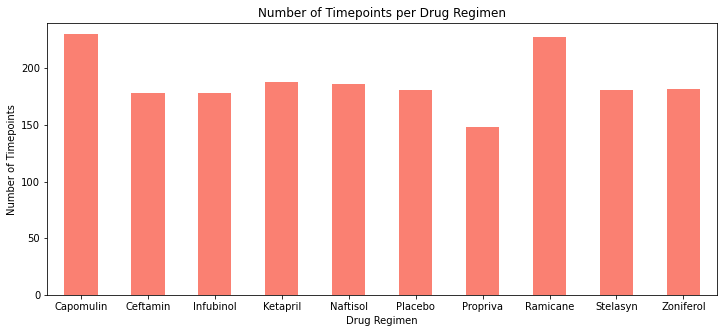

In [11]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.


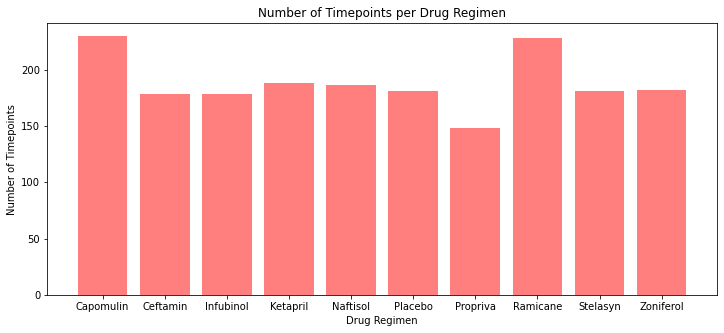

In [12]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
x_axis = np.arange(len(regimen_grouped_df))
# Here I am taking the index of the tumor statistics dataframe to get a list of drug regimens . . . 
# So that I can put this as the ticks for the x- axis
regimen_names = tumor_statistics_df.index
plt.figure(figsize=(12,5))
plt.bar(x_axis, tumor_count, color='r', alpha=0.5, align="center")
plt.xticks(x_axis, regimen_names, rotation='0')
plt.title("Number of Timepoints per Drug Regimen")
plt.ylabel("Number of Timepoints")
plt.xlabel("Drug Regimen")

#plt.tight_layout()
plt.show()

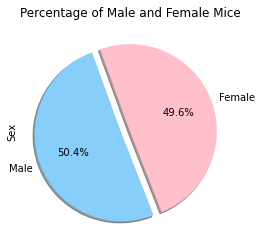

In [13]:
# # Generate a pie plot showing the distribution of female versus male mice using Pandas
# Currently the data set has each mouse listed multiple times for each Timepoint so I am going to create a new dataframe with . . .
# each mouse listed only once 
mouse_once_df = merge_df.drop_duplicates(subset="Mouse ID")
gender_counts = mouse_once_df["Sex"].value_counts()

colors = ["lightskyblue", "pink"]
explode = (0.1, 0)
gender_counts.plot(kind="pie",colors=colors, autopct="%1.1f%%", shadow=True, startangle=110, explode = explode, title ="Percentage of Male and Female Mice")
plt.show()

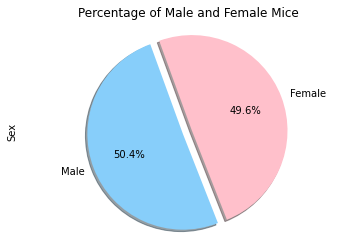

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
# Since the variables from the last part chart are already defined I can reuse them easily
# I need to use index to get the labels for the pie chart
labels = gender_counts.index
plt.pie(gender_counts, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=110, explode = explode)
plt.ylabel("Sex")
plt.title("Percentage of Male and Female Mice")
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# I will start by creating a new dataframe with just these treatment regimens 
specific_regimen = merge_df.loc[(merge_df["Drug Regimen"]=="Capomulin") | (merge_df["Drug Regimen"]=="Ramicane") | (merge_df["Drug Regimen"]=="Infubinol") | (merge_df["Drug Regimen"]=="Ceftamin"),:]

## Start by getting the last (greatest) timepoint for each mouse
# First I will group by Mouse ID
# Now I want the max timepoint for each Mouse ID
mouse_specificR_df = specific_regimen.groupby(["Mouse ID"])
timepoint_max = mouse_specificR_df['Timepoint'].max()
# In the timepoint_max dataframe the Mouse IDs are the index so I am going to extract the values
timepoint_max_ID = timepoint_max.index
# Create another list to extract just the max timepoints
timepoint_max_l = []
for x in range(len(timepoint_max)):
    timepoint_max_l.append(timepoint_max[x])

In [16]:
# Now I want to search through the dataframe with only the 4 regimens and create a new dataframe . . .
# that only has the rows with each Mouse IDs greatest time 
# With my list of Mouse IDs and their corresponding max times I am going to loop through the data frame and create a list with the max tumor volume for each mouse

# Create an empty list to store the max tumor vol data
max_tumor_list_lists = []
drug_regimen_list_lists = []
for x in range(len(timepoint_max)):
    max_tumor_list_lists.append(specific_regimen["Tumor Volume (mm3)"].loc[(specific_regimen["Mouse ID"]== timepoint_max_ID[x]) & (specific_regimen["Timepoint"]== timepoint_max[x])])
    drug_regimen_list_lists.append(specific_regimen["Drug Regimen"].loc[(specific_regimen["Mouse ID"]== timepoint_max_ID[x]) & (specific_regimen["Timepoint"]== timepoint_max[x])])
    # I printed the max_tumor_list and say it too many extra characters so I am going to trim these out
    max_tumor_list_lists[x] = max_tumor_list_lists[x].tolist()
    drug_regimen_list_lists[x] = drug_regimen_list_lists[x].tolist()

# Now I now to create another list because max_tumor_list_lists is a list a lists and I want it to be a list of values
max_tumor_list = []
drug_regimen_list = []
for x in range(len(max_tumor_list_lists)):
    max_tumor_list.append(max_tumor_list_lists[x][0])
    drug_regimen_list.append(drug_regimen_list_lists[x][0])

# Now I can create a new dataframe with just the max tumors 
max_tumors_df = pd.DataFrame(timepoint_max_ID)
max_tumors_df["Timepoint"] = timepoint_max_l
max_tumors_df["Tumor Volume (mm3)"] = max_tumor_list
max_tumors_df["Drug Regimen"] = drug_regimen_list

In [17]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 

drug_regimen_list = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
drugT_values = []

for x in range(len(drug_regimen_list)):
    tumor_max_by_drug = max_tumors_df.loc[max_tumors_df["Drug Regimen"]==drug_regimen_list[x],"Tumor Volume (mm3)"]
    drugT_values.append(tumor_max_by_drug)
    drug_regimen_df = max_tumors_df.loc[max_tumors_df["Drug Regimen"]==drug_regimen_list[x]]
    quartiles = tumor_max_by_drug.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f"{drug_regimen_list[x]}")
    print(f"{drug_regimen_list[x]}: lower quartile {lowerq}")
    print(f"{drug_regimen_list[x]}: upper quartile {upperq}")
    print(f"{drug_regimen_list[x]}: interquartile {iqr}")
    print(f"{drug_regimen_list[x]}: median {quartiles[0.5]}")

    # This is a standard calculation to find outliers 
    # Lower Quartile - 1.5*IQR anything lower than this can be considered an outlier
    # Upper Quartile + 1.5*IQR anything higher than this can be considered an outlier
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"{drug_regimen_list[x]}: lower bound {lower_bound}")
    print(f"{drug_regimen_list[x]}: upper bound {upper_bound}")  
    # Determine outliers based on upper and lower bounds
    outlier_mice = drug_regimen_df["Mouse ID"].loc[(drug_regimen_df['Tumor Volume (mm3)'] < lower_bound) | (drug_regimen_df['Tumor Volume (mm3)'] > upper_bound)]
    outlier_mice = outlier_mice.tolist()
    if len(outlier_mice) == 0:
        print(f"There are no outliers for {drug_regimen_list[x]}")
    else:
        print(f"The following mice are outliers for {drug_regimen_list[x]}: {outlier_mice[0]}")
    print("           ")
    print("           ")

Capomulin
Capomulin: lower quartile 32.37735684
Capomulin: upper quartile 40.1592203
Capomulin: interquartile 7.781863460000004
Capomulin: median 38.1251644
Capomulin: lower bound 20.70456164999999
Capomulin: upper bound 51.83201549
There are no outliers for Capomulin
           
           
Ramicane
Ramicane: lower quartile 31.56046955
Ramicane: upper quartile 40.65900627
Ramicane: interquartile 9.098536719999998
Ramicane: median 36.56165229
Ramicane: lower bound 17.912664470000003
Ramicane: upper bound 54.30681135
There are no outliers for Ramicane
           
           
Infubinol
Infubinol: lower quartile 54.04860769
Infubinol: upper quartile 65.52574285
Infubinol: interquartile 11.477135160000003
Infubinol: median 60.16518046
Infubinol: lower bound 36.83290494999999
Infubinol: upper bound 82.74144559000001
The following mice are outliers for Infubinol: c326
           
           
Ceftamin
Ceftamin: lower quartile 48.72207785
Ceftamin: upper quartile 64.29983003
Ceftamin: interqua

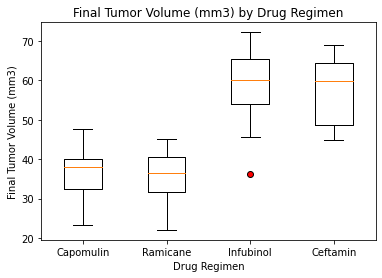

In [18]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
outlier_format = dict(marker = "o", markerfacecolor='r')
plt.boxplot(drugT_values, flierprops = outlier_format)
plt.xticks([1, 2, 3, 4], ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])
plt.title('Final Tumor Volume (mm3) by Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Final Tumor Volume (mm3)')
plt.show()

## Line and Scatter Plots

In [19]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
Capomulin_total_df = merge_df.loc[merge_df["Drug Regimen"] == "Capomulin"]
mice_capomulin = Capomulin_total_df["Mouse ID"].unique()

In [20]:
# Randomly select a mouse that received the Capomulin drug and create a dataframe for this mouse
mouse_index = randrange(len(mice_capomulin))
individual_mouse = Capomulin_total_df.loc[merge_df["Mouse ID"] == mice_capomulin[mouse_index]]
print(mice_capomulin[mouse_index])

w914


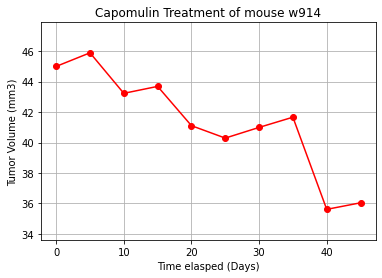

In [21]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
timepoints_capo = individual_mouse["Timepoint"]
tumV_capo = individual_mouse["Tumor Volume (mm3)"]
plt.plot(timepoints_capo, tumV_capo, marker="o", color="red")
plot_title = "Capomulin Treatment of mouse " + mice_capomulin[mouse_index]
plt.title(plot_title)
plt.xlabel("Time elasped (Days)")
plt.ylabel("Tumor Volume (mm3)")


plt.ylim(min(tumV_capo)-2, max(tumV_capo)+2)
plt.grid()

plt.show()

## Correlation and Regression

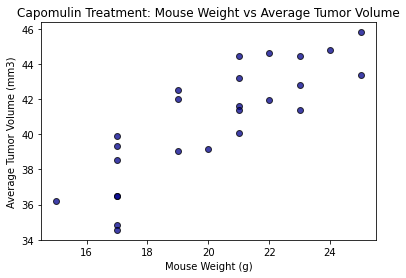

In [22]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

# I already have a dataframe with just the capomulin drug so I will use this. 
# I am going to groupby Mouse ID so I can easily calculate the average tumor volume for each mouse
mouse_group_capo = Capomulin_total_df.groupby(["Mouse ID"])
tumor_capo_mean = mouse_group_capo['Tumor Volume (mm3)'].mean()
weight_capo_mean = mouse_group_capo['Weight (g)'].mean()
plt.scatter(weight_capo_mean, tumor_capo_mean, marker = "o", facecolors="darkblue", edgecolors="black", alpha =0.75)
plt.title("Capomulin Treatment: Mouse Weight vs Average Tumor Volume")
plt.xlabel("Mouse Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

In [23]:
# Calculate the correlation coefficient
correlation = st.pearsonr(weight_capo_mean, tumor_capo_mean)
print(f"The correlation mouse weight and average tumor volume for the Capomulin drug is {round(correlation[0],2)}")

The correlation mouse weight and average tumor volume for the Capomulin drug is 0.84


The r-squared is: 0.7088568047708717


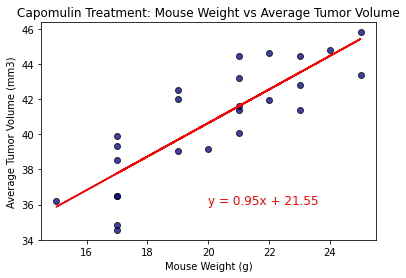

In [24]:
# Plot Linear regression 
(slope, intercept, rvalue, pvalue, stderr) = linregress(weight_capo_mean, tumor_capo_mean)
regress_values = weight_capo_mean * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(weight_capo_mean, tumor_capo_mean, marker = "o", facecolors="darkblue", edgecolors="black", alpha =0.75)
plt.plot(weight_capo_mean,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=12,color="red")
plt.title("Capomulin Treatment: Mouse Weight vs Average Tumor Volume")
plt.xlabel("Mouse Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [28]:
print(type(weight_capo_mean))

<class 'pandas.core.series.Series'>
